In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# import seaborn as sns
import librosa
import librosa.display
import IPython


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm
torch.manual_seed(42)

import seaborn as sns
sns.set()


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [12]:
Crema_Path='../input/speech-emotion-recognition-en/Crema/'
Ravdess_Path='../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/'
Savee_Path='../input/speech-emotion-recognition-en/Savee/'
Tess_Path='../input/speech-emotion-recognition-en/Tess/'

# **CREMA PREPROCESSING**

In [13]:
crema = []
for wav in sorted(os.listdir(Crema_Path)):
    emotion = wav.partition(".wav")[0].split('_')
    if emotion[2] == 'SAD':
        crema.append(('Sad', Crema_Path+'/'+wav))
    elif emotion[2] == 'ANG':
        crema.append(('Anger', Crema_Path+'/'+wav))
    elif emotion[2] == 'DIS':
        crema.append(('Disgust', Crema_Path+'/'+wav))
    elif emotion[2] == 'FEA':
        crema.append(('Fear', Crema_Path+'/'+wav))
    elif emotion[2] == 'HAP':
        crema.append(('Happy', Crema_Path+'/'+wav))
    elif emotion[2] == 'NEU':
        crema.append(('Neutral', Crema_Path+'/'+wav))
    else:
        crema.append(('unknown', Crema_Path+'/'+wav))

df = pd.DataFrame.from_records(crema, columns=['Emotion', 'File_Path'])
df.head()


,Emotion,File_Path
0,Anger,../input/speech-emotion-recognition-en/Crema//...
1,Disgust,../input/speech-emotion-recognition-en/Crema//...
2,Fear,../input/speech-emotion-recognition-en/Crema//...
3,Happy,../input/speech-emotion-recognition-en/Crema//...
4,Neutral,../input/speech-emotion-recognition-en/Crema//...


# **RAVDESS PREPROCESSING**

In [4]:
ravdess_directory_list = os.listdir(Ravdess_Path)

file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess_Path + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        if int(part[2]) != 2:
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess_Path + i + '/' + f)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])
path_df = pd.DataFrame(file_path, columns=['File_Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.Emotion.replace({1:'Neutral', 3:'Happy', 4:'Sad', 5:'Anger', 6:'Fear', 7:'Disgust', 8:'Surprise'},
                            inplace=True)
print(df.head())

    Emotion                                          File_Path
0  Surprise  ../input/speech-emotion-recognition-en/Ravdess...
1   Neutral  ../input/speech-emotion-recognition-en/Ravdess...
2   Disgust  ../input/speech-emotion-recognition-en/Ravdess...
3   Disgust  ../input/speech-emotion-recognition-en/Ravdess...
4   Neutral  ../input/speech-emotion-recognition-en/Ravdess...


# **SAVEE PREPROCESSING**

In [5]:
savee_directory_list = os.listdir(Savee_Path)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('Anger')
    elif ele=='d':
        file_emotion.append('Disgust')
    elif ele=='f':
        file_emotion.append('Fear')
    elif ele=='h':
        file_emotion.append('Happy')
    elif ele=='n':
        file_emotion.append('Neutral')
    elif ele=='sa':
        file_emotion.append('Sad')
    else:
        file_emotion.append('Surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['File_Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.head()

NameError: name 'Savee' is not defined

# **TESS PREPROCESSING**

In [ ]:
tess_directory_list = os.listdir(Tess_Path)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess_Path + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('Surprise')
        elif part == 'fear':
            file_emotion.append('Fear')
        elif part == 'sad':
            file_emotion.append('Sad')
        elif part == 'angry':
            file_emotion.append('Anger')
        elif part == 'disgust':
            file_emotion.append('Disgust')
        elif part == 'happy':
            file_emotion.append('Happy')
        elif part == 'neutral':
            file_emotion.append('Neutral')
        file_path.append(Tess_Path + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotion'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['File_Path'])
df = pd.concat([emotion_df, path_df], axis=1)
df.head()

In [15]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder 
encoder = LabelEncoder()
# Fit the encoder on the column and transform the values
df['Emotion_encoded'] = encoder.fit_transform(df['Emotion'])

# Get the mapping between original labels and encoded values
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))


In [16]:
label_mapping

{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5}

In [17]:
df['Emotion'].unique()

array(['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
      dtype=object)

In [18]:
emotion_names=df['Emotion'].unique()

In [9]:
!pip install torchaudio

In [19]:
import torchaudio
import torchaudio.transforms as transforms

S_dB_Total = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(df.File_Path)):
    waveform, sample_rate = torchaudio.load(path)
    
    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)

    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)
    
    S = mel_transform(waveform)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)

    S_dB_Total.append(S_dB.squeeze())

0it [00:00, ?it/s]/tmp/ipykernel_35/2468677012.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torch.tensor(waveform).to(device)
7442it [01:34, 78.39it/s]


In [20]:
sizes=[]
for x in S_dB_Total:
    sizes.append(x.shape[1])

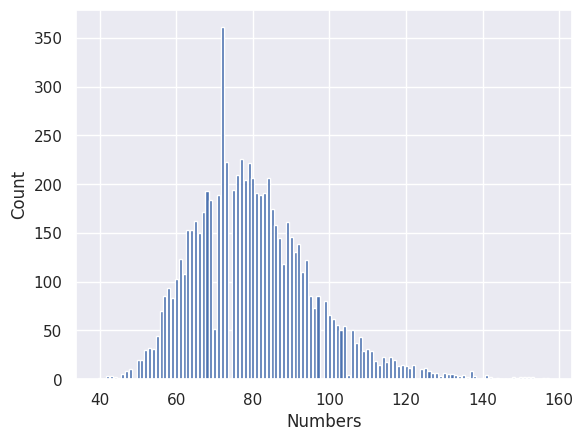

min is 40
max is 157


In [21]:
# Calculate the bin counts
bincount_array = np.histogram(sizes, bins=np.arange(min(sizes), max(sizes)+2))[0]

# Create a list of labels for the x-axis
x_labels = np.arange(min(sizes), max(sizes)+1)

# Plot the bin counts as a bar plot
plt.bar(x_labels, bincount_array)

# Set labels and title
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.show()

print(f'min is {min(sizes)}')
print(f'max is {max(sizes)}')


In [22]:
padding_length = 160
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
data_2D = np.array(padded_list)
    

In [23]:
data_2D.shape

(7442, 128, 160)

In [24]:
#normalization
from sklearn.preprocessing import MinMaxScaler

# Reshape the array to 2D
reshaped_data = data_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(data_2D.shape)


In [25]:
normalized_data[1]

array([[0.56973195, 0.5444743 , 0.51813316, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.5450095 , 0.5570548 , 0.541499  , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.512481  , 0.55639714, 0.592978  , ..., 0.64415836, 0.64415836,
        0.64415836],
       ...,
       [0.4755556 , 0.472118  , 0.4689895 , ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.4661117 , 0.45966327, 0.44934118, ..., 0.64415836, 0.64415836,
        0.64415836],
       [0.448575  , 0.45664725, 0.44868642, ..., 0.64415836, 0.64415836,
        0.64415836]], dtype=float32)

In [26]:
data=np.expand_dims(normalized_data, axis=1)

In [27]:
labels=df.Emotion_encoded.to_numpy()

In [28]:
labels.shape

(7442,)

In [29]:
data.shape

(7442, 1, 128, 160)

In [30]:
#train test split
from sklearn.model_selection import train_test_split
# Perform the train-test split (70% train & validation, 30% test )
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Perform the train-validation split (5% test, 95% train)
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size=0.1, stratify=y_trainAndVal, random_state=42)

# Print the sizes of each split
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Train set size: 5357
Validation set size: 596
Test set size: 1489


In [31]:
X_train.shape

(5357, 1, 128, 160)

In [32]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self,audio,label):
        self.audios=audio
        self.labels=label

    def __len__(self):
        return len(self.audios)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.audios[idx]
    
    def get_batch_labels(self, idx):
    # Fetch a batch of inputs
        return self.labels[idx]

    
    def __getitem__(self, index):
        audios=self.get_batch_imgs(index)
        labels=self.get_batch_labels(index)
        return audios,labels


In [33]:
train_dataset = AudioDataset(X_train,y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# Create a DataLoader from the dataset

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader=DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader=DataLoader(test_dataset, batch_size=8, shuffle=False)


# Architecture

In [35]:
class VisionTransformer(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        
        # ViT Feature Extractor and Model Initialization
        model_name = 'google/vit-base-patch16-224-in21k'
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
        self.model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_labels)
        
    def forward(self, x):
        # Forward pass through ViT model
        outputs = self.model(x)
        return outputs

In [ ]:
from torchinfo import summary
# need device to instantiate model
device = 'cuda'

# instantiate model for 8 emotions and move to GPU 
model = VisionTransformer(6).to(device)

In [39]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    for train_input, train_label in tqdm(data_loader):
        train_label = train_label.to(device)
        train_input = train_input.to(device)

        optimizer.zero_grad()
        
        output_logits, output_softmax = model(train_input.float())
        predictions = torch.argmax(output_softmax,dim=1)
        total_predictions += train_label.size(0)
        
        correct_predictions += (predictions == train_label).sum().item()
        
        loss = loss_fn(output_logits, train_label)

        losses.append(loss.item())


        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']}")

    accuracy = correct_predictions / total_predictions
    mean_loss = np.mean(losses)

    return mean_loss, accuracy


In [40]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():            
        for val_input, val_label in data_loader:
            val_label = val_label.to(device)
            val_input = val_input.to(device)

            optimizer.zero_grad()

            output_logits, output_softmax = model(val_input.float())

            predictions = torch.argmax(output_softmax,dim=1)
            total_predictions += val_label.size(0)

            correct_predictions += (predictions == val_label).sum().item()

            loss = loss_fn(output_logits, val_label)

            losses.append(loss.item())
            
            



        accuracy = correct_predictions / total_predictions
        mean_loss = np.mean(losses)
        

    return mean_loss, accuracy

In [43]:
model.load_state_dict(torch.load('/kaggle/working/best_model_state.bin'))

<All keys matched successfully>

In [46]:
def get_predicted(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for test_input, test_label in data_loader:
            test_label = test_label.to(device)
            test_input = test_input.to(device)

            output_logits, output_softmax = model(test_input.float())

            predictions = torch.argmax(output_softmax, dim=1)
            predicted_labels.extend(predictions.cpu().numpy())
            true_labels.extend(test_label.cpu().numpy())

            loss = loss_fn(output_logits, test_label)
            losses.append(loss.item())

    mean_loss = np.mean(losses)

    return mean_loss, predicted_labels, true_labels

In [47]:
mean_loss, predicted_labels, true_labels=get_predicted(model,test_dataloader,loss_fn,DEVICE)

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report,confusion_matrix

import matplotlib.pyplot as plt
def measurements_of_accuracy(Y_test,Y_pred,classifier,labels):
    # Calculate the confusion matrix
#     conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
#     matrix_precentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
#     fig, ax = plt.subplots(figsize=(5, 5))
#     ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
#     for i in range(conf_matrix.shape[0]):
#         for j in range(conf_matrix.shape[1]):
#             ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
 
#     plt.xlabel('Predictions', fontsize=18)
#     plt.ylabel('Actuals', fontsize=18)
#     plt.title("Confusion Matrix for "+classifier+"Classifier", fontsize=18)
#     plt.grid(False)
#     plt.xticks(range(len(labels)), labels, rotation=90)  # Set x-axis labels
#     plt.yticks(range(len(labels)), labels)  # Set y-axis labels
#     plt.show()
    
#     #Accuracy
#     print('Accuracy : %.4f' % accuracy_score(Y_test, Y_pred))

#     #precision score
#     print('Precision : %.4f' % precision_score(Y_test, Y_pred,average='macro'))
    
#     #Recall Score
#     print('Recall : %.4f' % recall_score(Y_test, Y_pred,average='macro'))
    
#     #F1 score
#     print('F1 Score : %.4f' % f1_score(Y_test, Y_pred,average='macro'))
    
#         # Find the most confusing classes
#     misclassification_rates = 1 - np.diag(matrix_precentage)
#     most_confusing_classes = [labels[i] for i in np.argsort(misclassification_rates)[::-1]]
#     print("Most Confusing Classes:")
#     for i, label in enumerate(most_confusing_classes):
#         rate_percentage = misclassification_rates[i] * 100
#         print(f"{i + 1}. {label}: {rate_percentage:.2f}% (Misclassification rate)")
    cm = confusion_matrix(Y_test, Y_pred)
    report = classification_report(Y_test, Y_pred, target_names=labels)
    
    print('Classification Report:')
    print(report)
    
    sns.set()
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True,fmt='d', cmap='Blues', annot_kws={"fontsize": 18}, xticklabels=labels, yticklabels=labels)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted labels', size=14)
    plt.ylabel('True labels', size=14)
    plt.show()


In [49]:
label_mapping

{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5}

In [51]:
import torch.optim as optim
EPOCHS=500
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn =nn.CrossEntropyLoss().to(DEVICE)

LEARNING_RATE=1e-4
model = ParaNetTransformer(6).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [52]:
from collections import defaultdict
import math
history = defaultdict(list)
loss=math.inf
epochs_without_improvement = 0
patience = 30  # Number of epochs to wait for improvement

In [53]:
for epoch in range(EPOCHS):


    train_loss,train_acc = train_epoch(model,train_dataloader,loss_fn, optimizer, DEVICE)
    
    val_loss,val_acc = eval_model(model,val_dataloader,loss_fn, DEVICE)
    
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    print(f'Train loss {train_loss}')
    print(f'Train Accuracy {train_acc}')

    print(f'Val   loss {val_loss}')
    print(f'Val   Acc {val_acc}')

    print()
        
    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Early stopping condition
    if epochs_without_improvement == patience:
        print("Early stopping triggered. No improvement in", patience, "epochs.")
        break



    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    
    history['train_Accuracy'].append(train_acc)
    history['val_Accuracy'].append(val_acc)

    #save this incase of failure
    torch.save(model.state_dict(), 'current_model_state.bin')
    
    
#save last state to train later
torch.save(model.state_dict(), 'last_model_state.bin')


100%|██████████| 670/670 [00:13<00:00, 50.41it/s]


Epoch 1, Learning Rate: 0.0001
Epoch 1/500
----------
Train loss 1.7413966224264743
Train Accuracy 0.32368863169684525
Val   loss 1.4979756991068522
Val   Acc 0.31543624161073824



100%|██████████| 670/670 [00:13<00:00, 50.43it/s]


Epoch 2, Learning Rate: 0.0001
Epoch 2/500
----------
Train loss 1.5830998247239128
Train Accuracy 0.36942318461825646
Val   loss 1.3942477774620057
Val   Acc 0.4278523489932886



100%|██████████| 670/670 [00:13<00:00, 50.06it/s]


Epoch 3, Learning Rate: 0.0001
Epoch 3/500
----------
Train loss 1.5104290162449452
Train Accuracy 0.3923837969012507
Val   loss 1.3728240617116292
Val   Acc 0.39932885906040266



100%|██████████| 670/670 [00:13<00:00, 50.79it/s]


Epoch 4, Learning Rate: 0.0001
Epoch 4/500
----------
Train loss 1.4457185663394074
Train Accuracy 0.4142243793167818
Val   loss 1.467364592552185
Val   Acc 0.35067114093959734



100%|██████████| 670/670 [00:13<00:00, 50.27it/s]


Epoch 5, Learning Rate: 0.0001
Epoch 5/500
----------
Train loss 1.419952872617921
Train Accuracy 0.4327048721299235
Val   loss 1.3197264830271402
Val   Acc 0.45302013422818793



100%|██████████| 670/670 [00:13<00:00, 48.61it/s]


Epoch 6, Learning Rate: 0.0001
Epoch 6/500
----------
Train loss 1.391093829585545
Train Accuracy 0.44241179764793725
Val   loss 1.3389324688911437
Val   Acc 0.4546979865771812



100%|██████████| 670/670 [00:13<00:00, 50.10it/s]


Epoch 7, Learning Rate: 0.0001
Epoch 7/500
----------
Train loss 1.3587748414544918
Train Accuracy 0.45734552921411237
Val   loss 1.3528699056307474
Val   Acc 0.4395973154362416



100%|██████████| 670/670 [00:13<00:00, 50.29it/s]


Epoch 8, Learning Rate: 0.0001
Epoch 8/500
----------
Train loss 1.3449526539489405
Train Accuracy 0.46275900690685084
Val   loss 1.2562366000811258
Val   Acc 0.4848993288590604



100%|██████████| 670/670 [00:13<00:00, 49.72it/s]


Epoch 9, Learning Rate: 0.0001
Epoch 9/500
----------
Train loss 1.3099717117957215
Train Accuracy 0.48105282807541533
Val   loss 1.245976734161377
Val   Acc 0.5167785234899329



100%|██████████| 670/670 [00:13<00:00, 48.33it/s]


Epoch 10, Learning Rate: 0.0001
Epoch 10/500
----------
Train loss 1.2904953784462232
Train Accuracy 0.4864663057681538
Val   loss 1.2240632724761964
Val   Acc 0.5268456375838926



100%|██████████| 670/670 [00:13<00:00, 49.83it/s]


Epoch 11, Learning Rate: 0.0001
Epoch 11/500
----------
Train loss 1.2652380924616287
Train Accuracy 0.493559828262087
Val   loss 1.1904582293828327
Val   Acc 0.5318791946308725



100%|██████████| 670/670 [00:13<00:00, 48.60it/s]


Epoch 12, Learning Rate: 0.0001
Epoch 12/500
----------
Train loss 1.2472996959935374
Train Accuracy 0.5112936344969199
Val   loss 1.1664735396703085
Val   Acc 0.5671140939597316



100%|██████████| 670/670 [00:13<00:00, 49.93it/s]


Epoch 13, Learning Rate: 0.0001
Epoch 13/500
----------
Train loss 1.232357703660851
Train Accuracy 0.5150270673884637
Val   loss 1.1877255392074586
Val   Acc 0.5469798657718121



100%|██████████| 670/670 [00:13<00:00, 50.40it/s]


Epoch 14, Learning Rate: 0.0001
Epoch 14/500
----------
Train loss 1.2308778537298317
Train Accuracy 0.5070001866716446
Val   loss 1.1664200854301452
Val   Acc 0.5536912751677853



100%|██████████| 670/670 [00:13<00:00, 49.71it/s]


Epoch 15, Learning Rate: 0.0001
Epoch 15/500
----------
Train loss 1.200961538837917
Train Accuracy 0.5234272913944372
Val   loss 1.156036891937256
Val   Acc 0.5536912751677853



100%|██████████| 670/670 [00:13<00:00, 49.36it/s]


Epoch 16, Learning Rate: 0.0001
Epoch 16/500
----------
Train loss 1.1766139849353192
Train Accuracy 0.5387343662497667
Val   loss 1.1376780899365744
Val   Acc 0.5704697986577181



100%|██████████| 670/670 [00:13<00:00, 49.18it/s]


Epoch 17, Learning Rate: 0.0001
Epoch 17/500
----------
Train loss 1.1708062405016886
Train Accuracy 0.5351876050028
Val   loss 1.1226895809173585
Val   Acc 0.5805369127516778



100%|██████████| 670/670 [00:13<00:00, 50.41it/s]


Epoch 18, Learning Rate: 0.0001
Epoch 18/500
----------
Train loss 1.1524526698375817
Train Accuracy 0.5493746499906664
Val   loss 1.130127507050832
Val   Acc 0.5654362416107382



100%|██████████| 670/670 [00:13<00:00, 49.79it/s]


Epoch 19, Learning Rate: 0.0001
Epoch 19/500
----------
Train loss 1.1400008130429395
Train Accuracy 0.5547881276834049
Val   loss 1.1357274452845256
Val   Acc 0.5503355704697986



100%|██████████| 670/670 [00:13<00:00, 50.53it/s]


Epoch 20, Learning Rate: 0.0001
Epoch 20/500
----------
Train loss 1.1320541568211655
Train Accuracy 0.5531080828822101
Val   loss 1.1375314895311992
Val   Acc 0.5771812080536913



100%|██████████| 670/670 [00:13<00:00, 49.69it/s]


Epoch 21, Learning Rate: 0.0001
Epoch 21/500
----------
Train loss 1.1175211494538322
Train Accuracy 0.5536680978159417
Val   loss 1.1101851518948873
Val   Acc 0.5553691275167785



100%|██████████| 670/670 [00:13<00:00, 50.62it/s]


Epoch 22, Learning Rate: 0.0001
Epoch 22/500
----------
Train loss 1.1074628140054532
Train Accuracy 0.5652417397797275
Val   loss 1.1183174645900726
Val   Acc 0.5855704697986577



100%|██████████| 670/670 [00:13<00:00, 50.37it/s]


Epoch 23, Learning Rate: 0.0001
Epoch 23/500
----------
Train loss 1.0975002662014606
Train Accuracy 0.5728952772073922
Val   loss 1.1325126338005065
Val   Acc 0.5486577181208053



100%|██████████| 670/670 [00:13<00:00, 50.29it/s]


Epoch 24, Learning Rate: 0.0001
Epoch 24/500
----------
Train loss 1.087537111408675
Train Accuracy 0.5770020533880903
Val   loss 1.1551135150591532
Val   Acc 0.5436241610738255



100%|██████████| 670/670 [00:13<00:00, 50.64it/s]


Epoch 25, Learning Rate: 0.0001
Epoch 25/500
----------
Train loss 1.0850707254747847
Train Accuracy 0.5684151577375397
Val   loss 1.0806484929720561
Val   Acc 0.5788590604026845



100%|██████████| 670/670 [00:13<00:00, 49.72it/s]


Epoch 26, Learning Rate: 0.0001
Epoch 26/500
----------
Train loss 1.0703196884980841
Train Accuracy 0.5807354862796341
Val   loss 1.0576043899854024
Val   Acc 0.5973154362416108



100%|██████████| 670/670 [00:13<00:00, 50.58it/s]


Epoch 27, Learning Rate: 0.0001
Epoch 27/500
----------
Train loss 1.0520298432503175
Train Accuracy 0.592495799887997
Val   loss 1.0364293575286865
Val   Acc 0.6124161073825504



100%|██████████| 670/670 [00:13<00:00, 49.61it/s]


Epoch 28, Learning Rate: 0.0001
Epoch 28/500
----------
Train loss 1.0532290816307068
Train Accuracy 0.5910024267313795
Val   loss 1.0644413530826569
Val   Acc 0.5822147651006712



100%|██████████| 670/670 [00:13<00:00, 49.89it/s]


Epoch 29, Learning Rate: 0.0001
Epoch 29/500
----------
Train loss 1.0374084101239247
Train Accuracy 0.5947358596229233
Val   loss 1.0737147279580435
Val   Acc 0.5973154362416108



100%|██████████| 670/670 [00:13<00:00, 50.18it/s]


Epoch 30, Learning Rate: 0.0001
Epoch 30/500
----------
Train loss 1.0210154267834193
Train Accuracy 0.6064961732312861
Val   loss 1.0572520271937051
Val   Acc 0.6040268456375839



100%|██████████| 670/670 [00:13<00:00, 50.66it/s]


Epoch 31, Learning Rate: 0.0001
Epoch 31/500
----------
Train loss 1.0207421554558314
Train Accuracy 0.6035094269180511
Val   loss 1.0456398550669352
Val   Acc 0.5973154362416108



100%|██████████| 670/670 [00:13<00:00, 50.29it/s]


Epoch 32, Learning Rate: 0.0001
Epoch 32/500
----------
Train loss 0.9972370487095704
Train Accuracy 0.6119096509240246
Val   loss 1.0266923693815868
Val   Acc 0.6157718120805369



100%|██████████| 670/670 [00:13<00:00, 50.36it/s]


Epoch 33, Learning Rate: 0.0001
Epoch 33/500
----------
Train loss 1.0079797984281582
Train Accuracy 0.6150830688818368
Val   loss 1.0399615828196207
Val   Acc 0.6308724832214765



100%|██████████| 670/670 [00:13<00:00, 50.19it/s]


Epoch 34, Learning Rate: 0.0001
Epoch 34/500
----------
Train loss 0.9884141145357445
Train Accuracy 0.6165764420384544
Val   loss 1.0447410972913107
Val   Acc 0.6124161073825504



100%|██████████| 670/670 [00:13<00:00, 50.35it/s]


Epoch 35, Learning Rate: 0.0001
Epoch 35/500
----------
Train loss 0.9714077612357354
Train Accuracy 0.6311368303154751
Val   loss 1.027246805826823
Val   Acc 0.5889261744966443



100%|██████████| 670/670 [00:13<00:00, 50.41it/s]


Epoch 36, Learning Rate: 0.0001
Epoch 36/500
----------
Train loss 0.9708449080808839
Train Accuracy 0.6268433824901998
Val   loss 1.0356046458085377
Val   Acc 0.6140939597315436



100%|██████████| 670/670 [00:13<00:00, 50.48it/s]


Epoch 37, Learning Rate: 0.0001
Epoch 37/500
----------
Train loss 0.9766428850924791
Train Accuracy 0.6203098749299981
Val   loss 0.9966726972659429
Val   Acc 0.62751677852349



100%|██████████| 670/670 [00:13<00:00, 50.33it/s]


Epoch 38, Learning Rate: 0.0001
Epoch 38/500
----------
Train loss 0.9498227695475764
Train Accuracy 0.629083442225126
Val   loss 1.0350335395336152
Val   Acc 0.6308724832214765



100%|██████████| 670/670 [00:13<00:00, 50.32it/s]


Epoch 39, Learning Rate: 0.0001
Epoch 39/500
----------
Train loss 0.9604579784532091
Train Accuracy 0.6300168004480119
Val   loss 1.059006609916687
Val   Acc 0.5788590604026845



100%|██████████| 670/670 [00:13<00:00, 50.30it/s]


Epoch 40, Learning Rate: 0.0001
Epoch 40/500
----------
Train loss 0.9317876207517154
Train Accuracy 0.6509240246406571
Val   loss 1.0075139848391215
Val   Acc 0.6258389261744967



100%|██████████| 670/670 [00:13<00:00, 50.54it/s]


Epoch 41, Learning Rate: 0.0001
Epoch 41/500
----------
Train loss 0.9331367812494733
Train Accuracy 0.6453238753033415
Val   loss 1.0037264406681061
Val   Acc 0.6090604026845637



100%|██████████| 670/670 [00:13<00:00, 50.21it/s]


Epoch 42, Learning Rate: 0.0001
Epoch 42/500
----------
Train loss 0.9263122472745269
Train Accuracy 0.6471905917491133
Val   loss 1.0014574042956035
Val   Acc 0.6157718120805369



100%|██████████| 670/670 [00:13<00:00, 50.29it/s]


Epoch 43, Learning Rate: 0.0001
Epoch 43/500
----------
Train loss 0.9114153444544593
Train Accuracy 0.6568975172671271
Val   loss 0.9781536368529001
Val   Acc 0.6325503355704698



100%|██████████| 670/670 [00:13<00:00, 50.13it/s]


Epoch 44, Learning Rate: 0.0001
Epoch 44/500
----------
Train loss 0.9110493144659854
Train Accuracy 0.6514840395743886
Val   loss 1.0362800105412802
Val   Acc 0.6090604026845637



100%|██████████| 670/670 [00:13<00:00, 50.35it/s]


Epoch 45, Learning Rate: 0.0001
Epoch 45/500
----------
Train loss 0.8848474615990226
Train Accuracy 0.653724099309315
Val   loss 1.0638636068503062
Val   Acc 0.6057046979865772



100%|██████████| 670/670 [00:13<00:00, 50.11it/s]


Epoch 46, Learning Rate: 0.0001
Epoch 46/500
----------
Train loss 0.902949467479293
Train Accuracy 0.6550308008213552
Val   loss 1.070174814860026
Val   Acc 0.5956375838926175



100%|██████████| 670/670 [00:13<00:00, 50.69it/s]


Epoch 47, Learning Rate: 0.0001
Epoch 47/500
----------
Train loss 0.8872186980807959
Train Accuracy 0.658764233712899
Val   loss 1.0281343110402426
Val   Acc 0.6258389261744967



100%|██████████| 670/670 [00:13<00:00, 50.40it/s]


Epoch 48, Learning Rate: 0.0001
Epoch 48/500
----------
Train loss 0.8929800292004401
Train Accuracy 0.6544707858876236
Val   loss 1.0172726170221964
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:13<00:00, 50.37it/s]


Epoch 49, Learning Rate: 0.0001
Epoch 49/500
----------
Train loss 0.887534936061546
Train Accuracy 0.6613776367369797
Val   loss 1.0434655968348185
Val   Acc 0.6124161073825504



100%|██████████| 670/670 [00:13<00:00, 50.57it/s]


Epoch 50, Learning Rate: 0.0001
Epoch 50/500
----------
Train loss 0.8575426968398379
Train Accuracy 0.6682844875863356
Val   loss 1.0196275579929353
Val   Acc 0.6157718120805369



100%|██████████| 670/670 [00:13<00:00, 49.96it/s]


Epoch 51, Learning Rate: 0.0001
Epoch 51/500
----------
Train loss 0.8701216807561134
Train Accuracy 0.6595109202912077
Val   loss 1.054441332221031
Val   Acc 0.6057046979865772



100%|██████████| 670/670 [00:13<00:00, 50.17it/s]


Epoch 52, Learning Rate: 0.0001
Epoch 52/500
----------
Train loss 0.8578451652357827
Train Accuracy 0.6714579055441479
Val   loss 0.9912075213591258
Val   Acc 0.6342281879194631



100%|██████████| 670/670 [00:13<00:00, 50.31it/s]


Epoch 53, Learning Rate: 0.0001
Epoch 53/500
----------
Train loss 0.8340716004149238
Train Accuracy 0.6789247713272354
Val   loss 0.9705350442727407
Val   Acc 0.6208053691275168



100%|██████████| 670/670 [00:13<00:00, 50.54it/s]


Epoch 54, Learning Rate: 0.0001
Epoch 54/500
----------
Train loss 0.8322200509149636
Train Accuracy 0.6763113683031547
Val   loss 1.0836229558785757
Val   Acc 0.587248322147651



100%|██████████| 670/670 [00:13<00:00, 50.59it/s]


Epoch 55, Learning Rate: 0.0001
Epoch 55/500
----------
Train loss 0.8391704973889821
Train Accuracy 0.6813515027067388
Val   loss 0.9833305319150288
Val   Acc 0.6342281879194631



100%|██████████| 670/670 [00:13<00:00, 50.23it/s]


Epoch 56, Learning Rate: 0.0001
Epoch 56/500
----------
Train loss 0.8315154824683916
Train Accuracy 0.6819115176404704
Val   loss 0.9743421173095703
Val   Acc 0.6308724832214765



100%|██████████| 670/670 [00:13<00:00, 50.79it/s]


Epoch 57, Learning Rate: 0.0001
Epoch 57/500
----------
Train loss 0.8169324227678242
Train Accuracy 0.6919917864476386
Val   loss 1.0152060850461324
Val   Acc 0.6241610738255033



100%|██████████| 670/670 [00:13<00:00, 50.10it/s]


Epoch 58, Learning Rate: 0.0001
Epoch 58/500
----------
Train loss 0.8005606656310273
Train Accuracy 0.6912450998693298
Val   loss 0.9824147266149521
Val   Acc 0.6325503355704698



100%|██████████| 670/670 [00:13<00:00, 50.43it/s]


Epoch 59, Learning Rate: 0.0001
Epoch 59/500
----------
Train loss 0.8022993601191399
Train Accuracy 0.6998319955198805
Val   loss 1.0889262588818869
Val   Acc 0.5922818791946308



100%|██████████| 670/670 [00:13<00:00, 49.14it/s]


Epoch 60, Learning Rate: 0.0001
Epoch 60/500
----------
Train loss 0.7906158389217818
Train Accuracy 0.7015120403210753
Val   loss 1.0136141761144002
Val   Acc 0.6291946308724832



100%|██████████| 670/670 [00:13<00:00, 50.07it/s]


Epoch 61, Learning Rate: 0.0001
Epoch 61/500
----------
Train loss 0.7811635508243717
Train Accuracy 0.7037521000560015
Val   loss 1.0832280353705088
Val   Acc 0.5855704697986577



100%|██████████| 670/670 [00:13<00:00, 49.83it/s]


Epoch 62, Learning Rate: 0.0001
Epoch 62/500
----------
Train loss 0.7732408222422671
Train Accuracy 0.704312114989733
Val   loss 0.9762760126590728
Val   Acc 0.6157718120805369



100%|██████████| 670/670 [00:13<00:00, 50.22it/s]


Epoch 63, Learning Rate: 0.0001
Epoch 63/500
----------
Train loss 0.7649644586132534
Train Accuracy 0.7099122643270487
Val   loss 1.0365830381711325
Val   Acc 0.6124161073825504



100%|██████████| 670/670 [00:13<00:00, 50.01it/s]


Epoch 64, Learning Rate: 0.0001
Epoch 64/500
----------
Train loss 0.761557937824904
Train Accuracy 0.712152324061975
Val   loss 1.021871742606163
Val   Acc 0.6291946308724832



100%|██████████| 670/670 [00:13<00:00, 49.50it/s]


Epoch 65, Learning Rate: 0.0001
Epoch 65/500
----------
Train loss 0.7683092043693386
Train Accuracy 0.7059921597909278
Val   loss 1.1683056775728862
Val   Acc 0.6057046979865772



100%|██████████| 670/670 [00:13<00:00, 49.86it/s]


Epoch 66, Learning Rate: 0.0001
Epoch 66/500
----------
Train loss 0.7513068622061566
Train Accuracy 0.7168191151764047
Val   loss 0.9934526836872101
Val   Acc 0.6375838926174496



100%|██████████| 670/670 [00:13<00:00, 49.98it/s]


Epoch 67, Learning Rate: 0.0001
Epoch 67/500
----------
Train loss 0.7518855609555742
Train Accuracy 0.7145790554414785
Val   loss 0.9904795809586843
Val   Acc 0.639261744966443



100%|██████████| 670/670 [00:13<00:00, 50.61it/s]


Epoch 68, Learning Rate: 0.0001
Epoch 68/500
----------
Train loss 0.7305347272931639
Train Accuracy 0.7235392943811835
Val   loss 0.9530975931882858
Val   Acc 0.6308724832214765



100%|██████████| 670/670 [00:13<00:00, 49.96it/s]


Epoch 69, Learning Rate: 0.0001
Epoch 69/500
----------
Train loss 0.7214803026572092
Train Accuracy 0.7296994586522307
Val   loss 1.0151618641614915
Val   Acc 0.6241610738255033



100%|██████████| 670/670 [00:13<00:00, 50.46it/s]


Epoch 70, Learning Rate: 0.0001
Epoch 70/500
----------
Train loss 0.7333100759271366
Train Accuracy 0.7240993093149151
Val   loss 0.9688699893156687
Val   Acc 0.6174496644295302



100%|██████████| 670/670 [00:13<00:00, 50.23it/s]


Epoch 71, Learning Rate: 0.0001
Epoch 71/500
----------
Train loss 0.73656318120992
Train Accuracy 0.7177524733992906
Val   loss 1.0222845538457235
Val   Acc 0.6073825503355704



100%|██████████| 670/670 [00:13<00:00, 49.81it/s]


Epoch 72, Learning Rate: 0.0001
Epoch 72/500
----------
Train loss 0.7194669068749271
Train Accuracy 0.7261526974052641
Val   loss 0.9858351775010427
Val   Acc 0.6493288590604027



100%|██████████| 670/670 [00:13<00:00, 49.83it/s]


Epoch 73, Learning Rate: 0.0001
Epoch 73/500
----------
Train loss 0.7050134536935322
Train Accuracy 0.7282060854956132
Val   loss 0.9443536845842997
Val   Acc 0.6493288590604027



100%|██████████| 670/670 [00:13<00:00, 49.38it/s]


Epoch 74, Learning Rate: 0.0001
Epoch 74/500
----------
Train loss 0.7022251127593553
Train Accuracy 0.7334328915437744
Val   loss 0.9664468975861867
Val   Acc 0.6409395973154363



100%|██████████| 670/670 [00:13<00:00, 50.33it/s]


Epoch 75, Learning Rate: 0.0001
Epoch 75/500
----------
Train loss 0.7109827039401923
Train Accuracy 0.7334328915437744
Val   loss 0.9968708765506744
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:13<00:00, 50.19it/s]


Epoch 76, Learning Rate: 0.0001
Epoch 76/500
----------
Train loss 0.6914181682823309
Train Accuracy 0.7407130856822849
Val   loss 1.0974242719014486
Val   Acc 0.6057046979865772



100%|██████████| 670/670 [00:13<00:00, 50.52it/s]


Epoch 77, Learning Rate: 0.0001
Epoch 77/500
----------
Train loss 0.6721175050891157
Train Accuracy 0.7466865783087548
Val   loss 1.010863069295883
Val   Acc 0.6325503355704698



100%|██████████| 670/670 [00:13<00:00, 49.96it/s]


Epoch 78, Learning Rate: 0.0001
Epoch 78/500
----------
Train loss 0.6919414939053024
Train Accuracy 0.7408997573268621
Val   loss 0.9895259310801824
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:13<00:00, 50.45it/s]


Epoch 79, Learning Rate: 0.0001
Epoch 79/500
----------
Train loss 0.6946427756058636
Train Accuracy 0.7338062348329288
Val   loss 1.0356629399458568
Val   Acc 0.62248322147651



100%|██████████| 670/670 [00:13<00:00, 50.41it/s]


Epoch 80, Learning Rate: 0.0001
Epoch 80/500
----------
Train loss 0.6736091667258027
Train Accuracy 0.7427664737726339
Val   loss 0.9781504156192143
Val   Acc 0.6258389261744967



100%|██████████| 670/670 [00:13<00:00, 49.94it/s]


Epoch 81, Learning Rate: 0.0001
Epoch 81/500
----------
Train loss 0.6843478954883654
Train Accuracy 0.7436998319955199
Val   loss 1.0294280854860942
Val   Acc 0.6208053691275168



100%|██████████| 670/670 [00:13<00:00, 50.59it/s]


Epoch 82, Learning Rate: 0.0001
Epoch 82/500
----------
Train loss 0.6767672190025671
Train Accuracy 0.7438865036400971
Val   loss 1.0449173148473103
Val   Acc 0.5956375838926175



100%|██████████| 670/670 [00:13<00:00, 50.52it/s]


Epoch 83, Learning Rate: 0.0001
Epoch 83/500
----------
Train loss 0.657915209367204
Train Accuracy 0.7537801008026881
Val   loss 0.970008295973142
Val   Acc 0.6325503355704698



100%|██████████| 670/670 [00:13<00:00, 50.92it/s]


Epoch 84, Learning Rate: 0.0001
Epoch 84/500
----------
Train loss 0.6579901384439931
Train Accuracy 0.754713459025574
Val   loss 0.9838210503260295
Val   Acc 0.639261744966443



100%|██████████| 670/670 [00:13<00:00, 50.19it/s]


Epoch 85, Learning Rate: 0.0001
Epoch 85/500
----------
Train loss 0.6437756427522026
Train Accuracy 0.7543401157364197
Val   loss 0.9585928869247436
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:13<00:00, 50.56it/s]


Epoch 86, Learning Rate: 0.0001
Epoch 86/500
----------
Train loss 0.6370277350740646
Train Accuracy 0.7599402650737354
Val   loss 0.9931131639083226
Val   Acc 0.6375838926174496



100%|██████████| 670/670 [00:13<00:00, 49.83it/s]


Epoch 87, Learning Rate: 0.0001
Epoch 87/500
----------
Train loss 0.6256016060265143
Train Accuracy 0.7642337128990107
Val   loss 0.9408179366588593
Val   Acc 0.6476510067114094



100%|██████████| 670/670 [00:13<00:00, 50.82it/s]


Epoch 88, Learning Rate: 0.0001
Epoch 88/500
----------
Train loss 0.619825079458863
Train Accuracy 0.7694605189471719
Val   loss 0.9784901479880015
Val   Acc 0.62751677852349



100%|██████████| 670/670 [00:13<00:00, 50.68it/s]


Epoch 89, Learning Rate: 0.0001
Epoch 89/500
----------
Train loss 0.6206401362125553
Train Accuracy 0.7642337128990107
Val   loss 0.9639338525136312
Val   Acc 0.6442953020134228



100%|██████████| 670/670 [00:13<00:00, 50.26it/s]


Epoch 90, Learning Rate: 0.0001
Epoch 90/500
----------
Train loss 0.6065322648455848
Train Accuracy 0.7720739219712526
Val   loss 1.0354934700330098
Val   Acc 0.6308724832214765



100%|██████████| 670/670 [00:13<00:00, 50.44it/s]


Epoch 91, Learning Rate: 0.0001
Epoch 91/500
----------
Train loss 0.6182378316881941
Train Accuracy 0.7717005786820982
Val   loss 0.9450419195493063
Val   Acc 0.6510067114093959



100%|██████████| 670/670 [00:13<00:00, 49.83it/s]


Epoch 92, Learning Rate: 0.0001
Epoch 92/500
----------
Train loss 0.6172967004019823
Train Accuracy 0.7698338622363263
Val   loss 0.9410339778661728
Val   Acc 0.6526845637583892



100%|██████████| 670/670 [00:13<00:00, 50.25it/s]


Epoch 93, Learning Rate: 0.0001
Epoch 93/500
----------
Train loss 0.6075179226585289
Train Accuracy 0.770580548814635
Val   loss 1.0229213345050812
Val   Acc 0.6208053691275168



100%|██████████| 670/670 [00:13<00:00, 49.90it/s]


Epoch 94, Learning Rate: 0.0001
Epoch 94/500
----------
Train loss 0.5936935289804616
Train Accuracy 0.774500653350756
Val   loss 0.9775140196084976
Val   Acc 0.6426174496644296



100%|██████████| 670/670 [00:13<00:00, 50.02it/s]


Epoch 95, Learning Rate: 0.0001
Epoch 95/500
----------
Train loss 0.5930540697009706
Train Accuracy 0.7782340862422998
Val   loss 0.9911999893188477
Val   Acc 0.6442953020134228



100%|██████████| 670/670 [00:13<00:00, 49.27it/s]


Epoch 96, Learning Rate: 0.0001
Epoch 96/500
----------
Train loss 0.5828470594068962
Train Accuracy 0.7864476386036962
Val   loss 1.033562564055125
Val   Acc 0.62248322147651



100%|██████████| 670/670 [00:13<00:00, 50.16it/s]


Epoch 97, Learning Rate: 0.0001
Epoch 97/500
----------
Train loss 0.5859287463740182
Train Accuracy 0.7767407130856823
Val   loss 1.0100097187360129
Val   Acc 0.6342281879194631



100%|██████████| 670/670 [00:13<00:00, 49.99it/s]


Epoch 98, Learning Rate: 0.0001
Epoch 98/500
----------
Train loss 0.5876253491406566
Train Accuracy 0.7786074295314541
Val   loss 0.9781582927703858
Val   Acc 0.62248322147651



100%|██████████| 670/670 [00:13<00:00, 49.99it/s]


Epoch 99, Learning Rate: 0.0001
Epoch 99/500
----------
Train loss 0.5639592971485942
Train Accuracy 0.7941011760313609
Val   loss 0.9861555529634157
Val   Acc 0.6459731543624161



100%|██████████| 670/670 [00:13<00:00, 50.48it/s]


Epoch 100, Learning Rate: 0.0001
Epoch 100/500
----------
Train loss 0.5652028767364239
Train Accuracy 0.784394250513347
Val   loss 1.010552302201589
Val   Acc 0.6241610738255033



100%|██████████| 670/670 [00:13<00:00, 49.87it/s]


Epoch 101, Learning Rate: 0.0001
Epoch 101/500
----------
Train loss 0.5654014526129658
Train Accuracy 0.7851409370916558
Val   loss 1.0086427036921184
Val   Acc 0.62248322147651



100%|██████████| 670/670 [00:13<00:00, 50.70it/s]


Epoch 102, Learning Rate: 0.0001
Epoch 102/500
----------
Train loss 0.5515973939602055
Train Accuracy 0.7916744446518574
Val   loss 1.0494586908817292
Val   Acc 0.6174496644295302



100%|██████████| 670/670 [00:13<00:00, 50.23it/s]


Epoch 103, Learning Rate: 0.0001
Epoch 103/500
----------
Train loss 0.5588341204477335
Train Accuracy 0.7905544147843943
Val   loss 0.9727979677915574
Val   Acc 0.6442953020134228



100%|██████████| 670/670 [00:13<00:00, 50.84it/s]


Epoch 104, Learning Rate: 0.0001
Epoch 104/500
----------
Train loss 0.5454972271154176
Train Accuracy 0.7961545641217099
Val   loss 1.06220715880394
Val   Acc 0.6325503355704698



100%|██████████| 670/670 [00:13<00:00, 50.32it/s]


Epoch 105, Learning Rate: 0.0001
Epoch 105/500
----------
Train loss 0.5409980042879261
Train Accuracy 0.8025014000373343
Val   loss 1.057420081893603
Val   Acc 0.6258389261744967



100%|██████████| 670/670 [00:13<00:00, 50.38it/s]


Epoch 106, Learning Rate: 0.0001
Epoch 106/500
----------
Train loss 0.522305559594907
Train Accuracy 0.8103416091095763
Val   loss 0.9353862522045772
Val   Acc 0.6526845637583892



100%|██████████| 670/670 [00:13<00:00, 50.38it/s]


Epoch 107, Learning Rate: 0.0001
Epoch 107/500
----------
Train loss 0.5352667689101019
Train Accuracy 0.7955945491879783
Val   loss 0.9744786103566487
Val   Acc 0.6426174496644296



100%|██████████| 670/670 [00:13<00:00, 50.32it/s]


Epoch 108, Learning Rate: 0.0001
Epoch 108/500
----------
Train loss 0.5353517607632857
Train Accuracy 0.7993279820795222
Val   loss 1.0064097795883815
Val   Acc 0.662751677852349



100%|██████████| 670/670 [00:13<00:00, 50.67it/s]


Epoch 109, Learning Rate: 0.0001
Epoch 109/500
----------
Train loss 0.5239184951882309
Train Accuracy 0.8019413851036028
Val   loss 1.0498189677794774
Val   Acc 0.6325503355704698



100%|██████████| 670/670 [00:13<00:00, 50.26it/s]


Epoch 110, Learning Rate: 0.0001
Epoch 110/500
----------
Train loss 0.5219131361693143
Train Accuracy 0.8092215792421131
Val   loss 0.9975607812404632
Val   Acc 0.6476510067114094



100%|██████████| 670/670 [00:13<00:00, 50.65it/s]


Epoch 111, Learning Rate: 0.0001
Epoch 111/500
----------
Train loss 0.5084101799319485
Train Accuracy 0.8069815195071869
Val   loss 1.1398234645525613
Val   Acc 0.6140939597315436



100%|██████████| 670/670 [00:13<00:00, 49.98it/s]


Epoch 112, Learning Rate: 0.0001
Epoch 112/500
----------
Train loss 0.5086941860393802
Train Accuracy 0.8107149523987306
Val   loss 0.9592651029427847
Val   Acc 0.6577181208053692



100%|██████████| 670/670 [00:13<00:00, 50.83it/s]


Epoch 113, Learning Rate: 0.0001
Epoch 113/500
----------
Train loss 0.48976826981377247
Train Accuracy 0.8163151017360463
Val   loss 1.0373761390646299
Val   Acc 0.6493288590604027



100%|██████████| 670/670 [00:13<00:00, 50.56it/s]


Epoch 114, Learning Rate: 0.0001
Epoch 114/500
----------
Train loss 0.4937638250527097
Train Accuracy 0.8187418331155497
Val   loss 1.1744960071643193
Val   Acc 0.6090604026845637



100%|██████████| 670/670 [00:13<00:00, 50.16it/s]


Epoch 115, Learning Rate: 0.0001
Epoch 115/500
----------
Train loss 0.48528253627079193
Train Accuracy 0.8189285047601269
Val   loss 1.0082549488544463
Val   Acc 0.6610738255033557



100%|██████████| 670/670 [00:13<00:00, 50.10it/s]


Epoch 116, Learning Rate: 0.0001
Epoch 116/500
----------
Train loss 0.4905319649503747
Train Accuracy 0.8181818181818182
Val   loss 1.039969696601232
Val   Acc 0.639261744966443



100%|██████████| 670/670 [00:13<00:00, 49.41it/s]


Epoch 117, Learning Rate: 0.0001
Epoch 117/500
----------
Train loss 0.48784858442064544
Train Accuracy 0.8178084748926638
Val   loss 1.1047569491465887
Val   Acc 0.6157718120805369



100%|██████████| 670/670 [00:13<00:00, 50.12it/s]


Epoch 118, Learning Rate: 0.0001
Epoch 118/500
----------
Train loss 0.484473693943513
Train Accuracy 0.8224752660070935
Val   loss 0.9787900597850482
Val   Acc 0.6459731543624161



100%|██████████| 670/670 [00:13<00:00, 49.74it/s]


Epoch 119, Learning Rate: 0.0001
Epoch 119/500
----------
Train loss 0.4637100178748369
Train Accuracy 0.8284487586335636
Val   loss 1.0279784925778708
Val   Acc 0.6510067114093959



100%|██████████| 670/670 [00:13<00:00, 50.40it/s]


Epoch 120, Learning Rate: 0.0001
Epoch 120/500
----------
Train loss 0.4750015343025104
Train Accuracy 0.8196751913384357
Val   loss 1.091790804862976
Val   Acc 0.62751677852349



100%|██████████| 670/670 [00:13<00:00, 49.78it/s]


Epoch 121, Learning Rate: 0.0001
Epoch 121/500
----------
Train loss 0.46840136993064807
Train Accuracy 0.8282620869889864
Val   loss 0.9912396500507991
Val   Acc 0.639261744966443



100%|██████████| 670/670 [00:13<00:00, 50.17it/s]


Epoch 122, Learning Rate: 0.0001
Epoch 122/500
----------
Train loss 0.4419065584942921
Train Accuracy 0.8340489079708793
Val   loss 1.070358742872874
Val   Acc 0.6342281879194631



100%|██████████| 670/670 [00:13<00:00, 49.88it/s]


Epoch 123, Learning Rate: 0.0001
Epoch 123/500
----------
Train loss 0.47223399662371
Train Accuracy 0.8219152510733619
Val   loss 1.0446942613522212
Val   Acc 0.6426174496644296



100%|██████████| 670/670 [00:13<00:00, 49.81it/s]


Epoch 124, Learning Rate: 0.0001
Epoch 124/500
----------
Train loss 0.4554643853053228
Train Accuracy 0.8282620869889864
Val   loss 1.0481244305769601
Val   Acc 0.6459731543624161



100%|██████████| 670/670 [00:13<00:00, 50.26it/s]


Epoch 125, Learning Rate: 0.0001
Epoch 125/500
----------
Train loss 0.45946648377758353
Train Accuracy 0.828822101922718
Val   loss 1.0837330933411915
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:13<00:00, 50.46it/s]


Epoch 126, Learning Rate: 0.0001
Epoch 126/500
----------
Train loss 0.465053594885255
Train Accuracy 0.823968639163711
Val   loss 0.9852517815430959
Val   Acc 0.6526845637583892



100%|██████████| 670/670 [00:13<00:00, 50.54it/s]


Epoch 127, Learning Rate: 0.0001
Epoch 127/500
----------
Train loss 0.4532809198180686
Train Accuracy 0.8306888183684898
Val   loss 1.0181634191672007
Val   Acc 0.6610738255033557



100%|██████████| 670/670 [00:13<00:00, 50.19it/s]


Epoch 128, Learning Rate: 0.0001
Epoch 128/500
----------
Train loss 0.4553092849899584
Train Accuracy 0.8338622363263021
Val   loss 1.0277552489439647
Val   Acc 0.6442953020134228



100%|██████████| 670/670 [00:13<00:00, 50.53it/s]


Epoch 129, Learning Rate: 0.0001
Epoch 129/500
----------
Train loss 0.4354533422237902
Train Accuracy 0.8428224752660071
Val   loss 1.084143443306287
Val   Acc 0.6359060402684564



100%|██████████| 670/670 [00:13<00:00, 50.36it/s]


Epoch 130, Learning Rate: 0.0001
Epoch 130/500
----------
Train loss 0.41658698570038843
Train Accuracy 0.8450625350009333
Val   loss 1.0588245542844137
Val   Acc 0.6409395973154363



100%|██████████| 670/670 [00:13<00:00, 50.62it/s]


Epoch 131, Learning Rate: 0.0001
Epoch 131/500
----------
Train loss 0.4353478567202145
Train Accuracy 0.8381556841515774
Val   loss 1.0555021798610686
Val   Acc 0.6409395973154363



100%|██████████| 670/670 [00:13<00:00, 50.46it/s]


Epoch 132, Learning Rate: 0.0001
Epoch 132/500
----------
Train loss 0.4205920386197629
Train Accuracy 0.8486092962478999
Val   loss 0.996219783226649
Val   Acc 0.6560402684563759



100%|██████████| 670/670 [00:13<00:00, 50.22it/s]


Epoch 133, Learning Rate: 0.0001
Epoch 133/500
----------
Train loss 0.4185973454433591
Train Accuracy 0.8420757886876984
Val   loss 1.0116172395149867
Val   Acc 0.6577181208053692



100%|██████████| 670/670 [00:13<00:00, 50.48it/s]


Epoch 134, Learning Rate: 0.0001
Epoch 134/500
----------
Train loss 0.41402928596501476
Train Accuracy 0.8415157737539668
Val   loss 1.065242657661438
Val   Acc 0.6325503355704698



100%|██████████| 670/670 [00:13<00:00, 49.84it/s]


Epoch 135, Learning Rate: 0.0001
Epoch 135/500
----------
Train loss 0.41302956534243784
Train Accuracy 0.847675938025014
Val   loss 1.0080920341610908
Val   Acc 0.6459731543624161



100%|██████████| 670/670 [00:13<00:00, 50.47it/s]


Epoch 136, Learning Rate: 0.0001
Epoch 136/500
----------
Train loss 0.41011383252690975
Train Accuracy 0.8467425798021281
Val   loss 1.063172839085261
Val   Acc 0.6493288590604027

Early stopping triggered. No improvement in 30 epochs.


In [54]:
model.load_state_dict(torch.load('/kaggle/working/current_model_state.bin'))

<All keys matched successfully>

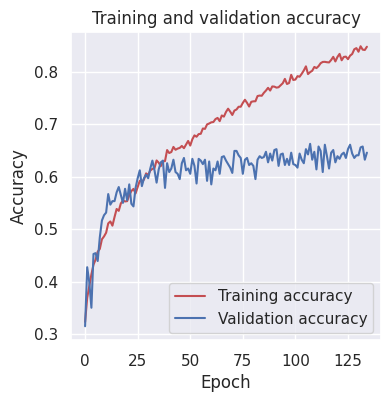

In [55]:
plt.figure(figsize=(4,4))
plt.plot(history['train_Accuracy'], 'r',label='Training accuracy')
plt.plot(history['val_Accuracy'], 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


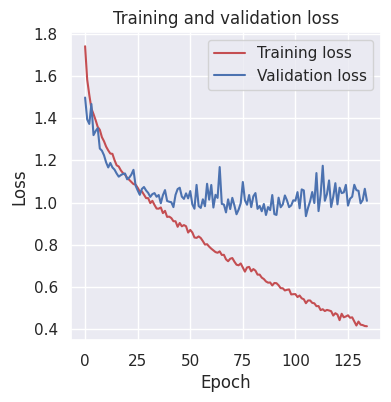

In [56]:
plt.figure(figsize=(4,4))
plt.plot(history['train_loss'], 'r', label='Training loss')
plt.plot(history['val_loss'], 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


In [57]:
mean_loss, predicted_labels, true_labels=get_predicted(model,test_dataloader,loss_fn,DEVICE)

Classification Report:
              precision    recall  f1-score   support

       Anger       0.78      0.74      0.76       254
     Disgust       0.63      0.55      0.59       254
        Fear       0.65      0.52      0.58       254
       Happy       0.71      0.60      0.65       255
     Neutral       0.63      0.89      0.74       218
         Sad       0.60      0.72      0.65       254

    accuracy                           0.66      1489
   macro avg       0.67      0.67      0.66      1489
weighted avg       0.67      0.66      0.66      1489



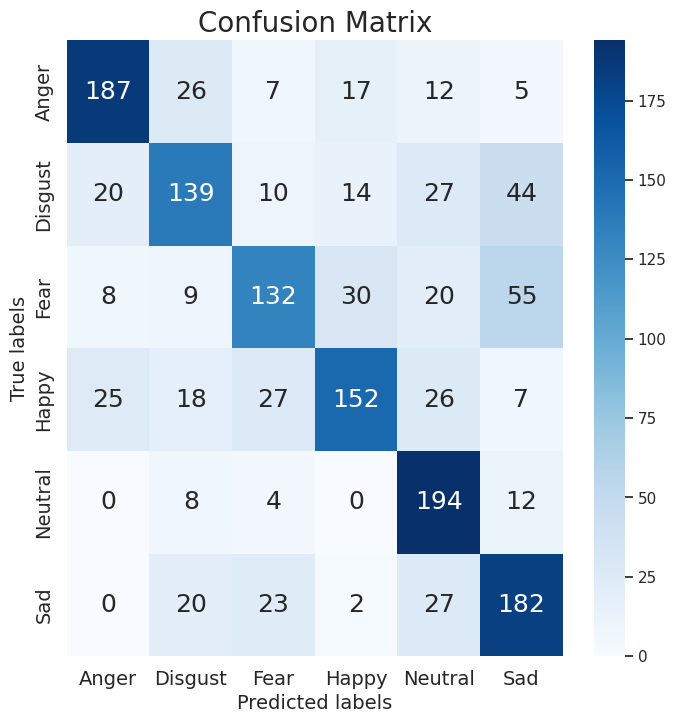

In [58]:
measurements_of_accuracy(true_labels,predicted_labels,"Confusion matrix",list(label_mapping.keys()))